  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-g1ljhqfk
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-g1ljhqfk
  Resolved https://github.com/tensorflow/docs to commit 6680535155460f7eb0d2d615b9749a0cf721d4ec
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=983e8aa8d91bf4573fa2cb238dec4b714741fe61e706a861953f28c457c8c87c
  Stored in directory: /tmp/pip-ephem-wheel-cache-je8o1y0h/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs
2816407858/2816407858 [==============================] - 82s 0us/step

Epoch: 0, accuracy:0.4975,  binary_crossentropy:0.7529,  loss:0.7529,  val_accuracy:0.4980,  val_binary_crossentropy:0.7191,  val_loss:0.7191,  
....................................................................................................
Epoch: 100, 

(0.5, 0.7)

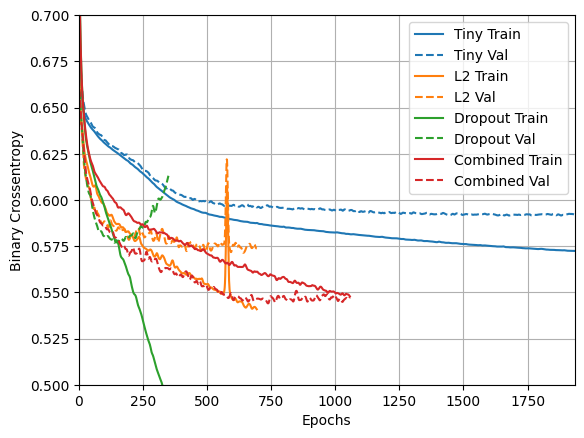

In [1]:
# 과적합과 과소적합
# 과적합 : 학습 데이터셋에 지나치게 최적화하여 발생하는 문제
# 과소적합 : 모델의 최적화가 제대로 수행되지 않아 학습 데이터의 구조/패턴을 정확히 반영하지 못하는 문제
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# 패키지 설치
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# 힉스(Higgs) 데이터셋
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

FEATURES = 28

# tf.data.experimental.CsvDataset 클래스는 중간 압축 해제 단계 없이 gzip 파일에서 직접 csv 레코드 읽는 데 사용 가능
ds = tf.data.experimental.CsvDataset(gz, [float(),] * (FEATURES + 1), compression_type='GZIP')

def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

# for features, label in packed_ds.batch(1000).take(1):
#     print(features[0])
#     plt.hist(features.numpy().flatten(), bins=101)

## 검증 및 훈련 데이터셋 분할
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN / BATCH_SIZE

# Dataset.cache 메서드를 사용해 로더가 각 epoch에서 파일의 데이터를 다시 읽을 필요가 없도록 함.
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# 과적합 예제
## 기존 모델 생성
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH * 1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# step = np.linspace(0, 100000)
# lr = lr_schedule(step)
# plt.figure(figsize=(8, 6))
# plt.plot(step / STEPS_PER_EPOCH, lr)
# plt.ylim([0, max(plt.ylim())])
# plt.xlabel("Epoch")
# _ = plt.ylabel("Learning Rate")

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(
                          from_logits=True,
                          name='binary_crossentropy'),
                      'accuracy'
                  ])
    # model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

## 미소 모델
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)])

size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
# plotter.plot(size_histories)
# plt.ylim([0.5, 0.7])

## 작은 모델
# 16개 단위가 있는 2개의 은닉층 사용
# small_model = tf.keras.Sequential([
#     # 'input_shape' is only required here so that '.summary' works.
#     layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
#     layers.Dense(16, activation='elu'),
#     layers.Dense(1)])

# size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

## 중간 모델
# 64개 단위가 있는 3개의 은닉층 사용
# medium_model = tf.keras.Sequential([
#     layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
#     layers.Dense(64, activation='elu'),
#     layers.Dense(64, activation='elu'),
#     layers.Dense(1)])

# size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

## 큰 모델
# 512개 단위가 있는 4개의 은닉층 사용
# large_model = tf.keras.Sequential([
#     layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(512, activation='elu'),
#     layers.Dense(1)])

# size_histories['Large'] = compile_and_fit(large_model, 'sizes/Large')

## 훈련 손실과 검증 손실 그래프 그리기
# plotter.plot(size_histories)
# a = plt.xscale("log")
# plt.xlim([5, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
# plt.xlabel("Epoch [Log Scale]")

## TensorBoard에서 보기
# docs_infra : no_execute

# Load the TensorBoard notebook extension
# %load_ext tensorboard

# Open an embedded TensorBoard viewer
# %tensorboard --logdir {logdir}/sizes

# display.IFrame(
#     src='https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97',
#     width='100%', height='800px')

# Share TensorBoard result
# !tensorboard dev upload --logdir {logdir}/sizes

# 과적합을 방지하기 위한 전략
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

## 가중치 규제
# L1 규제 : 가중치의 절댓값에 비례하는 비용 추가
# L2 규제 : 가중치의 제곱에 비례하는 비용 추가
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)])

regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

# plotter.plot(regularizer_histories)
# plt.ylim([0.5, 0.7])

## 드롭아웃 추가
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

# plotter.plot(regularizer_histories)
# plt.ylim([0.5, 0.7])

## L2 + 드롭아웃 결합
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.0001),
                 input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(1)])

regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined')

plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## TensorBoard에서 보기
# %load_ext tensorboard

# %tensorboard --logdir {logdir}/regularizers

# display.IFrame(
#     src='https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97',
#     width='100%', height='800px')

# !tensorboard dev upload --logdir {logdir}/regularizers

# 결론
# 과적합을 방지하는 방법 : 더 많은 훈련 데이터, 네트워크 용량 축소,
#                         가중치 정규화 추가, 드롭아웃 추가